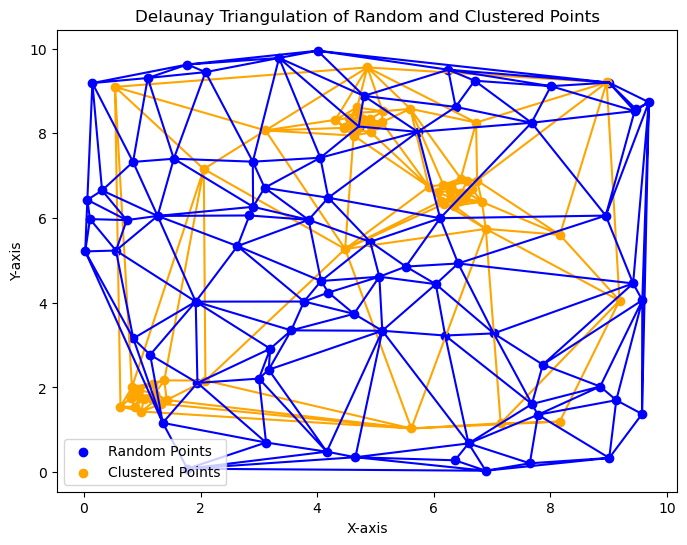

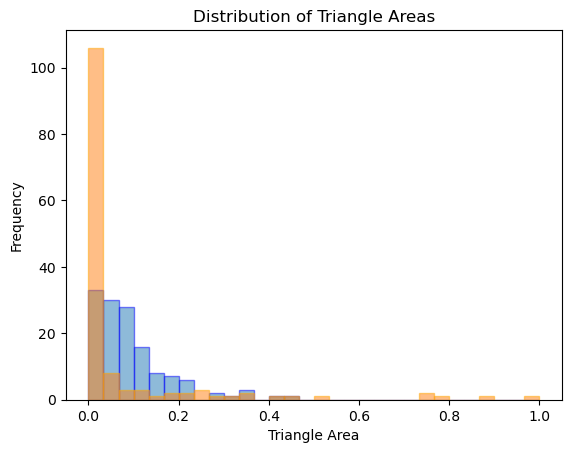

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


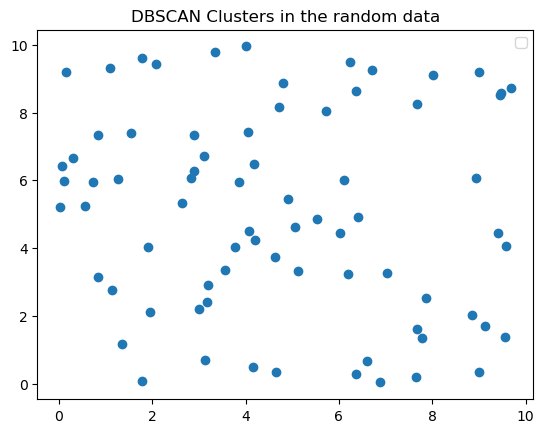

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<function matplotlib.pyplot.show(close=None, block=None)>

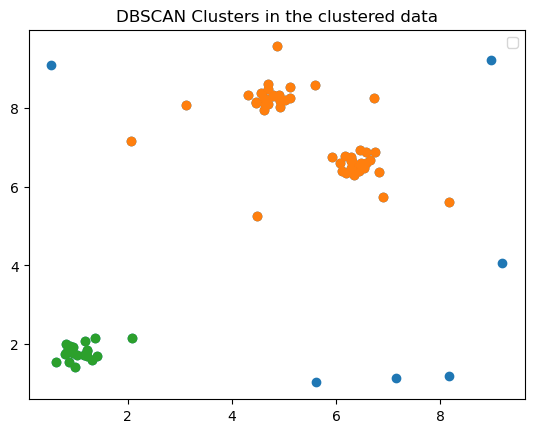

In [143]:
from sklearn.cluster import DBSCAN
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
# Set seed for reproducibility
np.random.seed(12)

# Function to generate points with clusters and noise
def generate_clustered_points(num_points_per_cluster, num_clusters, noise_std, noisy_points):
    points = []

    for cluster in range(num_clusters):
        # Generate cluster center
        center = np.random.rand(2) * 10  # Adjust the scale as needed

        # Generate points around the cluster center with noise
        cluster_points = center + np.random.normal(scale=noise_std, size=(num_points_per_cluster, 2))
        noise = np.random.rand(noisy_points, 2) * 10
        points.extend(cluster_points)
    points.extend(noise)

    return np.array(points)

def get_triangle_areas(triangulation, points):
    triangle_areas = []
    for simplex in triangulation.simplices:
        triangle = points[simplex]
        triangle_area = 0.5 * np.abs(np.cross(triangle[1] - triangle[0], triangle[2] - triangle[0]))
        triangle_areas.append(triangle_area)
    return triangle_areas


def edge_length(vertex1, vertex2):
    return np.linalg.norm(vertex2 - vertex1)

def get_edge_length(triangulation, points):
# Calculate edge lengths for each simplex
    edge_lengths = []
    for simplex in triangulation.simplices:
        for i in range(3):
            edge_lengths.append(edge_length(points[simplex[i]], points[simplex[(i + 1) % 3]]))
    return(edge_lengths)

# Parameters
num_points_random = 75
num_points_per_cluster = 20
num_clusters = 3
noise_std = 0.2
noisy_points = 15

# Generate random points
random_points = np.random.rand(num_points_random, 2) * 10  # Adjust the scale as needed

# Generate clustered points with noise
clustered_points = generate_clustered_points(num_points_per_cluster, num_clusters, noise_std, noisy_points)

# Concatenate random and clustered points
all_points = np.concatenate((random_points, clustered_points), axis=0)

# Perform Delaunay triangulation
triangulation_cluster = Delaunay(clustered_points)
triangulation_rand = Delaunay(random_points)


#get the distance of the vertices and normalise
tr_dist_cluster = get_edge_length(triangulation_cluster, clustered_points)
tr_dist_rand = get_edge_length(triangulation_rand, random_points)
max_tr_dist = max(*tr_dist_rand, *tr_dist_cluster)
tr_dist_rand_norm = tr_dist_rand/max_tr_dist
tr_dist_cluster_norm = tr_dist_cluster/max_tr_dist

#get the area of the vertices and normalise
trarea_rand = get_triangle_areas(triangulation_rand, random_points)
trarea_clustered = get_triangle_areas(triangulation_cluster, clustered_points)
max_tr_area = max(*trarea_rand, *trarea_clustered)
trarea_rand_norm = [x/max_tr_area for x in trarea_rand]
trarea_clustered_norm = [x/max_tr_area for x in trarea_clustered]


# Plotting
plt.figure(figsize=(8, 6))
# Plot random points in blue
plt.scatter(random_points[:, 0], random_points[:, 1], c='blue', label='Random Points')
# Plot clustered points in orange
plt.scatter(clustered_points[:, 0], clustered_points[:, 1], c='orange', label='Clustered Points')
# Plot Delaunay triangulation
plt.triplot(clustered_points[:, 0], clustered_points[:, 1], triangulation_cluster.simplices, color='orange')
plt.triplot(random_points[:, 0], random_points[:, 1], triangulation_rand.simplices, color='blue')

plt.title('Delaunay Triangulation of Random and Clustered Points')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()

bins = np.linspace(0, 1, 31) 
plt.hist(trarea_rand_norm, bins=bins, edgecolor='blue', alpha=0.5)
plt.hist(trarea_clustered_norm, bins=bins, edgecolor='orange', alpha=0.5)
plt.xlabel('Triangle Area')
plt.ylabel('Frequency')
plt.title('Distribution of Triangle Areas')
plt.show()


# Apply DBSCAN to the normalized data
dbscan = DBSCAN(eps=2, min_samples=20)
labels_clustered = dbscan.fit_predict(clustered_points)
labels_rand = dbscan.fit_predict(random_points)

plt.scatter(random_points[:, 0], random_points[:, 1], alpha=1)
for label in unique_labels_rand:
    mask = labels_rand == label
    if np.any(mask):
        print(mask)
        plt.scatter(random_points[mask, 0], random_points[mask, 1])

plt.title("DBSCAN Clusters in the random data")
plt.legend()
plt.show()

plt.scatter(clustered_points[:, 0], clustered_points[:, 1], alpha=1)
for label in unique_labels_clustered:
    mask = labels_clustered == label
    if np.any(mask):
        plt.scatter(clustered_points[mask, 0], clustered_points[mask, 1])

plt.title("DBSCAN Clusters in the clustered data")
plt.legend()
plt.show



In [39]:
import numpy as np
import pandas as pd
from glob import glob
import scripts.functions as fcts
from scipy.spatial import KDTree

#initialise paramaters for the detection/selection of synapses

params = {}
params['true_roi_size'] = (49660,49660,1100) #size of the 3d Tiff in microns
params['sf']  = (68, 68, 180) #defines the level of downsampling to create the filtered image
params['kernel_size'] = (40,40,2) #kernel size of the gaussian filter
params['sigma'] = 10 #intensity of the gaussian filter
params['max_threshold_ves'] = 4 #threshold for the extraction of intensity blobs in the image
params['min_peak_dist'] = 16 #min distance between 2 peaks (in pixels) - if distance is smaller, the 2 peaks are merged
params['min_cluster_area'] = 32 #min area of a cluster (in pixels)
params['max_cluster_area'] = 32000 #max area of a cluster (in pixels)

target_marker='PSD'
target_directory_drive = '/users/isabellegarnreiter/desktop/'

# Import all files (cell zones) under one experiment type, but for both dep and spon vesicle targets
# and store the data in dictionaries.

vesicles_data = {}
syn_marker_data = {}

target_directory = target_directory_drive
list_of_files = np.array([file for file in glob(target_directory + f'*/*{target_marker}*/*/*emix/*w*.csv')])

try:
    list_of_files = list_of_files.reshape(list_of_files.shape[0]//2,2)
except ValueError:
    print('Value Error: one channel is missing from one of the cellzones.')

    
# usable_exp = pd.read_csv('/users/isabellegarnreiter/documents/vesicleSTORM/data/STORM_binary_list.csv',encoding='latin', sep=',').to_numpy()
# filename  = usable_exp[:,0]+'_'+usable_exp[:,1]
# files_infos = dict(zip(filename, usable_exp[:,2:]))
vesicles_path = r'/Users/isabellegarnreiter/Desktop/PSD/210208 DEP647_PSD680 8DIV/CellZone2/Demix/CoordTable_SAFE360_MULTIPLEXING_demixed_w2_UncertaintyFiltered.csv'
PSD_path = r'/Users/isabellegarnreiter/Desktop/PSD/210208 DEP647_PSD680 8DIV/CellZone2/Demix/CoordTable_SAFE360_MULTIPLEXING_demixed_w1_UncertaintyFiltered.csv'

vesicles = pd.read_csv(vesicles_path)[['x [nm]', 'y [nm]', 'z [nm]']].to_numpy(dtype=np.float64)
vesicles[:,2] +=550

PSD = pd.read_csv(PSD_path)[['x [nm]', 'y [nm]', 'z [nm]']].to_numpy(dtype=np.float64)
PSD[:,2] +=550

vesicles_data = vesicles
syn_marker_data = PSD

image_size = (params['true_roi_size'][0]//params['sf'][0], params['true_roi_size'][1]//params['sf'][1], params['true_roi_size'][2]//params['sf'][2])
wfi = fcts.get_gaussiankde(vesicles_data, params)

masks_647 = fcts.get_clusters(wfi, params)
cluster_points_647 = fcts.get_points(vesicles_data, masks_647, params)
seperated_clusters_647 = fcts.seperate_clusters(masks_647)



In [30]:
import numpy as np
ch647 = np.load('/Users/isabellegarnreiter/Desktop/PSD/210212 DEP647_PSD680 8DIV/CellZone5/demix/data/points_647.npy', allow_pickle=True)[()]
ch680 = np.load('/Users/isabellegarnreiter/Desktop/PSD/210212 DEP647_PSD680 8DIV/CellZone5/demix/data/points_680.npy', allow_pickle=True)[()]
clusters = np.load('/Users/isabellegarnreiter/Desktop/PSD/210212 DEP647_PSD680 8DIV/CellZone5/demix/data/clusters_647.npy', allow_pickle=True)[()]


keys_647 = []
for key, value in ch647.items():
    keys_647.append(key)

keys_680 = []
for key, value in ch680.items():
    keys_680.append(key)
    

keys_clusters = []
for key, value in clusters.items():
    keys_clusters.append(key)

keys_647.sort()
keys_680.sort()
keys_clusters.sort()
print(keys_647)
print(keys_680)
print(keys_clusters)

[1, 2, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43]
[1, 2, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43]
[1, 2, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43]


In [29]:
def add_missing_keys(dict_a, dict_b):
    # Iterate over keys in dict_a
    for key in dict_a:
        # If key is not present in dict_b, add it with an empty list
        if key not in dict_b:
            dict_b[key] = []

# Example dictionaries
dict_a = {1: [1, 2, 3], 2: [4, 5], 3: [6, 7, 8, 9]}
dict_b = {1: [10, 11], 2: [12, 13]}

# Call the function to add missing keys to dict_b
add_missing_keys(dict_a, dict_b)

# Now, dict_b has the same keys as dict_a, with missing keys added and initialized with empty lists
print(dict_b)

{1: [10, 11], 2: [12, 13], 3: []}
